<a href="https://colab.research.google.com/github/may98ank/Codes/blob/master/HME_to_MathML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip "/content/drive/My Drive/data (1)/cleaned_mathML.zip" -d data/
# !unzip "/content/drive/My Drive/data (1)/hme_images.zip" -d data/

In [ ]:
%matplotlib inline
import torch
import numpy as np
import os, cv2
from torchvision import models
import torchvision.transforms as T
from torch import nn
from torch.autograd import Variable
from PIL import Image
from pprint import pprint
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
from torch import optim
from nltk.translate.bleu_score import sentence_bleu
import torch.nn.functional as F
import random

In [ ]:
MAX_LENGTH = 200

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def get_path(s):
    paths = {
        "Images" : "data/images/",
        "Vocab" : "data/kaggle/cleaned_mathml/vocab.csv",
        "MathML" : "data/kaggle/cleaned_mathml/"
    }
    return paths[s]

In [ ]:
Image_transform = T.Compose([
                    T.Resize(224),
                    T.CenterCrop(224),
                    T.ToTensor(), 
                    T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
                    ])

In [ ]:
Image_file_names = os.listdir(get_path("Images"))
MathML_file_names = os.listdir(get_path("MathML"))

temp_image = []
temp_mm = []

for mm_name in set(MathML_file_names):
    img_name = mm_name[:-4] + ".inkml.png"
    if(img_name in Image_file_names):
        temp_image.append(img_name)
        temp_mm.append(mm_name)

Image_file_names = temp_image
MathML_file_names = temp_mm
data_size = len(Image_file_names)

In [ ]:
wordtoint = {
    '<SOS>' : 0
}
inttoword = {
    0 : '<SOS>',
}
with open(get_path("Vocab")) as f:
    words = f.read().strip().split(" ")
    for e, word in enumerate(words):
        wordtoint[word] = e+1
        inttoword[e+1] = word
end = len(wordtoint)
wordtoint['<EOS>'] = end
inttoword[end] = '<EOS>'
SOS_token = 0
EOS_token = end

In [ ]:
def get_input_pair(index):
    img = Image.open(get_path("Images") + Image_file_names[index]).convert("RGB")
    img = Image_transform(img).unsqueeze(0)
    tar = None
    with open(get_path("MathML") + MathML_file_names[index]) as f:
        arr = f.read().strip().split(" ")
        tar = [torch.tensor([wordtoint[word]]) for word in arr]
    tar.append(torch.tensor([EOS_token]))
    tar = torch.tensor(tar).reshape(-1, 1)
    return img, tar

In [ ]:
# feature_extractor = models.densenet169(pretrained=True)

In [ ]:
# feature_extractor

In [ ]:
# modules = list(feature_extractor.children())[:-1]
# feature_extractor = nn.Sequential(*modules)
# ls = []
# for child in feature_extractor.children():
#     if(child == feature_extractor.Mixed_5d):
#         ls.append(child)
#         break
#     ls.append(child)
# feature_extractor = nn.Sequential(*ls)
feature_extractor = models.densenet169(pretrained=True)
ls = []
for child in feature_extractor.children():
    ls.append(child)

feature_extractor = ls[0]
ls = []
for child in feature_extractor.children():
    ls.append(child)
for ele in ls:
    print(type(ele))

feature_extractor = nn.Sequential(*ls[:-4])
ls = []
for child in feature_extractor.children():
    ls.append(child)
len(ls)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 57.8MB/s]


<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torchvision.models.densenet._DenseBlock'>
<class 'torchvision.models.densenet._Transition'>
<class 'torchvision.models.densenet._DenseBlock'>
<class 'torchvision.models.densenet._Transition'>
<class 'torchvision.models.densenet._DenseBlock'>
<class 'torchvision.models.densenet._Transition'>
<class 'torchvision.models.densenet._DenseBlock'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>


8

In [ ]:
%matplotlib inline
img, tar = get_input_pair(0)
feature_extractor.eval()
feature_extractor(img).shape

torch.Size([1, 256, 14, 14])

In [ ]:
# from graphviz import Digraph
# import re
# import torch
# import torch.nn.functional as F
# from torch.autograd import Variable
# import torchvision.models as models
# from torchviz import make_dot

# inputs = torch.randn( 1, 3, 224, 224)
# y = feature_extractor(inputs)

# # print(y)

# g = make_dot(y)
# g.view()

In [ ]:
# !pip install torchviz

In [ ]:
class Encoder(nn.Module):
    def __init__(self, feature_extractor, d_prob=0.1):
        super(Encoder, self).__init__()
        self.densenet = feature_extractor
        for p in self.densenet.parameters():
            p.requires_grad = False
        
        self.cnn1 = nn.Conv2d(256, 512, kernel_size=(1,1))
        # self.cnn2 = nn.Conv2d(512, 512, kernel_size=(1,1))
        self.cnn3 = nn.Conv2d(512, 350, kernel_size=(1,1))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(d_prob)

    def forward(self, image):
        output = self.densenet(image)
        output = self.relu(self.dropout(self.cnn1(output)))
        # output = self.relu(self.dropout(self.cnn2(output)))
        output = self.relu(self.dropout(self.cnn3(output)))
        return output

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, drop_prob=0.1, max_size=MAX_LENGTH):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.drop_prob = drop_prob
        self.max_size = max_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_size)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(drop_prob)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, inp, hidden, encoder_outputs):
        embedded = self.embedding(inp).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
#         print(attn_weights.shape)
#         print(encoder_outputs.shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, valid=False, max_length=MAX_LENGTH):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    target_length = target_tensor.size(0)
#     print(input_tensor.shape)
#     print(target_tensor.shape)
#     encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    encoder_outputs = encoder(input_tensor).reshape(200, -1)
    
    decoder_input = torch.tensor([[SOS_token]], device=device)
#     print(encoder_outputs.shape)
    
    decoder_hidden = decoder.initHidden()

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # print(target_tensor[di], decoder_output)
            loss += criterion(decoder_output, target_tensor[di])
            
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder( decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    if(not valid):
        loss = loss/target_length
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

    return loss.item()

In [ ]:
def Evaluate(encoder, decoder, indices):
    encoder = encoder.eval()
    decoder = decoder.eval()
    random.shuffle(indices)
    indices = indices[:1000]
    score = 0
    for idx in indices:
        img, tar = get_input_pair(idx)
        # plt.imshow(cv2.imread(get_path("Images") + Image_file_names[idx]))
        img = img.to(device)
        tar = tar.to(device)
        out = encoder(img).reshape(200, -1)
        hid = decoder.initHidden().to(device)
        start = torch.tensor([SOS_token]).to(device)
        with open(get_path("MathML") + MathML_file_names[idx]) as f:
            arr = f.read().strip().split(" ")
        pred = []
        for i in range(len(arr)):
            ans, hid, attn = decoder(start, hid, out)
            pred.append(inttoword[int(F.softmax(ans).argmax())])
            # print(inttoword[int(F.softmax(ans).argmax())],arr[i])
            start = F.softmax(ans).argmax()
        score += sentence_bleu(arr, pred)
    encoder = encoder.train()
    decoder = decoder.train()
    return score/1000

In [ ]:
def trainIters(encoder, decoder, n_iters, learning_rate=0.0001, e_start=1, min_avg_loss=None, last_bleu_score=0):
    start = time.time()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    encoder_optimizer = optim.Adam([{"params" : encoder.cnn1.parameters()},
                                #    {"params" : encoder.cnn2.parameters()},
                                   {"params" : encoder.cnn3.parameters()}]
                                  , lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()
    train_losses = []
    valid_losses = []
    bleu_scores = []
    # validation_data_index = data_index[int(data_size*0.9):]
    # if(len(train_data_index) + len(validation_data_index) != data_size):
    #     print("partition Is Not Good Dude!!")
    #     return
    for i in range(e_start, e_start + n_iters):
        data_index = list(range(data_size))
        random.shuffle(data_index)
        train_data_index = data_index[ : int(data_size*0.5)]
        total_loss = 0
        encoder = encoder.train()
        decoder = decoder.train()
        for k in train_data_index:
            input_tensor, target_tensor = get_input_pair(k)
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)
            loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            total_loss += loss

        loss_avg = total_loss/len(train_data_index)
        print('%s (%d %d%%) %.4f' % (timeSince(start, i / n_iters), i, i / n_iters * 100, loss_avg))
        train_losses.append(loss_avg)
        curr_score = Evaluate(encoder, decoder, data_index)
        bleu_scores.append(curr_score)
        # valid_loss = 0
        # encoder = encoder.eval()
        # decoder = decoder.eval()
        # for k in validation_data_index:
        #     input_tensor, target_tensor = get_input_pair(k)
        #     input_tensor = input_tensor.to(device)
        #     target_tensor = target_tensor.to(device)
        #     loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, valid=True)
        #     valid_loss += loss

        # avg_valid_loss = valid_loss/len(validation_data_index)
        # valid_losses.append(avg_valid_loss)

        # if(last_valid_loss == None or (avg_valid_loss < last_valid_loss)):
        #     last_valid_loss = avg_valid_loss
        #     print(f'Saving Model at Epoch: {i} with validation loss {avg_valid_loss}')
        #     save_state(i, encoder, encoder_optimizer, decoder, decoder_optimizer, avg_valid_loss)
        if last_bleu_score < curr_score:
            min_avg_loss = loss_avg
            last_bleu_score = curr_score
            print("Saving Model State at: ", i)
            save_state(i, encoder, encoder_optimizer, decoder, decoder_optimizer, min_avg_loss)
    showPlot(train_losses, bleu_scores, 'red')

In [ ]:
def showPlot(points1, points2, color):
    %matplotlib inline
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points1, color='red')
    plt.plot(points2, color='blue')

In [ ]:
def save_state(epoch, encoder, encoder_optimizer, decoder, decoder_optimizer, loss):
    torch.save({
            'epoch': epoch,
            'loss' : loss,
            'encoder_state_dict': encoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            }, "/content/drive/My Drive/data/checkpoint/checkpoint"+ ".pth")

In [ ]:
encoder = Encoder(feature_extractor)
decoder = Decoder(343, len(wordtoint))
# model_states = torch.load('../input/modeltest/checkpoint7.pth', map_location=device)
# encoder.load_state_dict(model_states["encoder_state_dict"])
# decoder.load_state_dict(model_states["decoder_state_dict"])
trainIters(encoder, decoder, 20)

KeyboardInterrupt: ignored

In [ ]:
trainIters(encoder, decoder, 10, e_start=11)

11m 27s (- -2m 57s) (11 110%) 1.7043


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


UnboundLocalError: ignored

In [ ]:
def train_from_checkpoint(path, device=device):
    model_states = torch.load(path, map_location=device)
    encoder = Encoder(feature_extractor).to(device)
    decoder = Decoder(343, len(wordtoint)).to(device)
    encoder.load_state_dict(model_states["encoder_state_dict"])
    decoder.load_state_dict(model_states["decoder_state_dict"])
    loss = model_states["loss"]
    start = model_states["epoch"]
    epochs = 30
    arr = list(range(data_size))
    last_bleu_score = Evaluate(encoder, decoder, arr)
    trainIters(encoder, decoder, epochs, e_start=start+1, min_avg_loss=loss, last_bleu_score = last_bleu_score)

10m 58s (- -7m 47s) (69 229%) 1.0409


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


23m 0s (- -14m 50s) (70 233%) 1.0119
Saving Model State at:  70
35m 5s (- -21m 44s) (71 236%) 1.0111
Saving Model State at:  71
47m 9s (- -28m 29s) (72 240%) 0.9873
Saving Model State at:  72
59m 15s (- -35m 5s) (73 243%) 1.0020
71m 19s (- -43m 35s) (74 246%) 0.9752
Saving Model State at:  74
83m 20s (- -51m 59s) (75 250%) 0.9742
Saving Model State at:  75
95m 19s (- -58m 18s) (76 253%) 0.9290
Saving Model State at:  76
107m 17s (- -66m 30s) (77 256%) 0.9546
119m 11s (- -74m 39s) (78 260%) 0.9606
131m 8s (- -82m 39s) (79 263%) 0.9206
Saving Model State at:  79
143m 11s (- -90m 30s) (80 266%) 0.9404
155m 10s (- -98m 17s) (81 270%) 0.9262
167m 4s (- -106m 3s) (82 273%) 0.9309
179m 4s (- -115m 39s) (83 276%) 0.9274
191m 3s (- -123m 10s) (84 280%) 0.9039
Saving Model State at:  84
203m 9s (- -132m 32s) (85 283%) 0.8990
Saving Model State at:  85
215m 8s (- -141m 54s) (86 286%) 0.8907
Saving Model State at:  86
227m 12s (- -149m 8s) (87 290%) 0.8933
239m 21s (- -158m 14s) (88 293%) 0.8911
2

<Figure size 432x288 with 0 Axes>

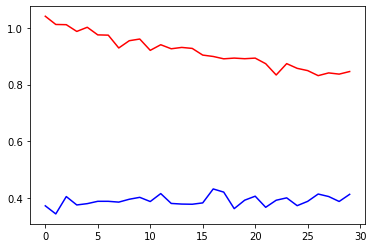

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

11m 1s (- -8m 24s) (96 320%) 0.8121


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Saving Model State at:  96
23m 12s (- -17m 57s) (97 323%) 0.8388
35m 29s (- -25m 22s) (98 326%) 0.8342
47m 38s (- -34m 47s) (99 330%) 0.8116
Saving Model State at:  99
59m 50s (- -42m 6s) (100 333%) 0.8164
72m 17s (- -51m 10s) (101 336%) 0.7975
Saving Model State at:  101
84m 53s (- -60m 4s) (102 340%) 0.8024
97m 21s (- -69m 0s) (103 343%) 0.8099
109m 58s (- -79m 44s) (104 346%) 0.8040
122m 26s (- -88m 32s) (105 350%) 0.8055
134m 58s (- -97m 13s) (106 353%) 0.7899
Saving Model State at:  106
147m 29s (- -107m 51s) (107 356%) 0.7866
Saving Model State at:  107
159m 57s (- -116m 28s) (108 360%) 0.7901
172m 38s (- -126m 52s) (109 363%) 0.7913
185m 12s (- -135m 18s) (110 366%) 0.7739
Saving Model State at:  110
197m 42s (- -145m 43s) (111 370%) 0.7704
Saving Model State at:  111
210m 18s (- -154m 1s) (112 373%) 0.7549
Saving Model State at:  112
222m 49s (- -164m 20s) (113 376%) 0.7389
Saving Model State at:  113
235m 20s (- -174m 35s) (114 380%) 0.7534
247m 47s (- -184m 50s) (115 383%) 0.

<Figure size 432x288 with 0 Axes>

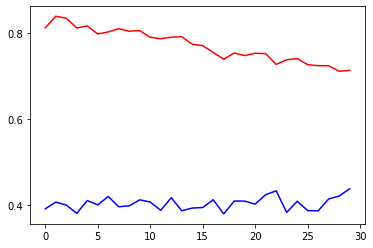

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

7m 48s (- -6m 4s) (125 416%) 0.7260


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


16m 28s (- -13m 27s) (126 420%) 0.7289
25m 6s (- -20m 49s) (127 423%) 0.7133
33m 46s (- -26m 8s) (128 426%) 0.7006
Saving Model State at:  128
42m 15s (- -33m 34s) (129 430%) 0.7143
50m 45s (- -40m 57s) (130 433%) 0.6925
Saving Model State at:  130
59m 22s (- -46m 13s) (131 436%) 0.6821
Saving Model State at:  131
67m 43s (- -53m 40s) (132 440%) 0.6941


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


76m 12s (- -60m 59s) (133 443%) 0.7067
84m 30s (- -66m 24s) (134 446%) 0.6838
92m 28s (- -72m 4s) (135 450%) 0.6688
Saving Model State at:  135
100m 19s (- -79m 48s) (136 453%) 0.6752
108m 12s (- -85m 29s) (137 456%) 0.6855
116m 5s (- -91m 8s) (138 459%) 0.6689
123m 54s (- -98m 49s) (139 463%) 0.6742
131m 49s (- -104m 25s) (140 466%) 0.6721
139m 43s (- -111m 59s) (141 470%) 0.6662
Saving Model State at:  141
147m 37s (- -117m 33s) (142 473%) 0.6831
155m 29s (- -123m 7s) (143 476%) 0.6737
163m 23s (- -130m 39s) (144 480%) 0.6482
Saving Model State at:  144
171m 8s (- -136m 15s) (145 483%) 0.6561
179m 2s (- -143m 44s) (146 486%) 0.6549
186m 49s (- -149m 18s) (147 490%) 0.6234
Saving Model State at:  147
194m 38s (- -156m 48s) (148 493%) 0.6253
202m 24s (- -162m 20s) (149 496%) 0.6469
210m 15s (- -169m 47s) (150 500%) 0.6534
218m 3s (- -175m 16s) (151 503%) 0.6373
225m 57s (- -182m 38s) (152 506%) 0.6422
233m 50s (- -188m 0s) (153 509%) 0.6327
241m 44s (- -195m 21s) (154 513%) 0.6283


<Figure size 432x288 with 0 Axes>

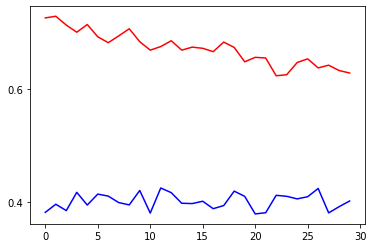

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

10m 48s (- -9m 5s) (170 566%) 0.5281


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Saving Model State at:  170
22m 51s (- -19m 9s) (171 570%) 0.5401
34m 53s (- -29m 11s) (172 573%) 0.5370
46m 52s (- -39m 15s) (173 576%) 0.5468
58m 52s (- -49m 16s) (174 580%) 0.5264
Saving Model State at:  174
70m 45s (- -59m 22s) (175 583%) 0.5278
82m 45s (- -69m 20s) (176 586%) 0.5085
Saving Model State at:  176
94m 38s (- -79m 24s) (177 590%) 0.5253
106m 30s (- -89m 26s) (178 593%) 0.5124
118m 26s (- -99m 24s) (179 596%) 0.5117
130m 15s (- -109m 27s) (180 600%) 0.5095
142m 10s (- -119m 23s) (181 603%) 0.5064
Saving Model State at:  181
154m 14s (- -129m 11s) (182 606%) 0.5122
166m 10s (- -139m 4s) (183 610%) 0.5028
Saving Model State at:  183
178m 11s (- -150m 51s) (184 613%) 0.4826
Saving Model State at:  184
190m 5s (- -160m 43s) (185 616%) 0.5061
202m 13s (- -170m 23s) (186 620%) 0.5096
214m 13s (- -180m 8s) (187 623%) 0.4938
226m 10s (- -191m 55s) (188 626%) 0.5084
238m 10s (- -201m 38s) (189 630%) 0.5014
249m 48s (- -211m 38s) (190 633%) 0.4918
261m 19s (- -221m 42s) (191 636%

<Figure size 432x288 with 0 Axes>

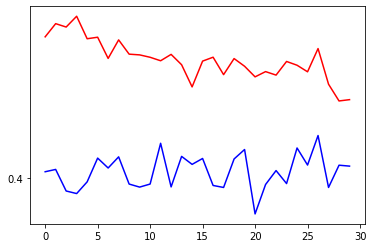

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

cuda


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


8m 13s (- -7m 0s) (199 663%) 0.4990
17m 11s (- -15m 23s) (200 666%) 0.4922
26m 0s (- -23m 52s) (201 670%) 0.4898
34m 45s (- -30m 24s) (202 673%) 0.4839
43m 35s (- -38m 51s) (203 676%) 0.4916
Saving Model State at:  203
52m 32s (- -45m 11s) (204 680%) 0.4850
Saving Model State at:  204
61m 16s (- -53m 41s) (205 683%) 0.4700
70m 9s (- -60m 3s) (206 686%) 0.4666
78m 58s (- -68m 27s) (207 690%) 0.4701
87m 44s (- -76m 54s) (208 693%) 0.4833
96m 34s (- -83m 17s) (209 696%) 0.4864
105m 19s (- -91m 43s) (210 700%) 0.4823
114m 7s (- -98m 5s) (211 703%) 0.4811
123m 0s (- -106m 23s) (212 706%) 0.4697
131m 51s (- -114m 42s) (213 710%) 0.4696
140m 48s (- -122m 55s) (214 713%) 0.4921
149m 43s (- -129m 9s) (215 716%) 0.4764
158m 31s (- -137m 29s) (216 720%) 0.4766
167m 24s (- -145m 44s) (217 723%) 0.4870
176m 13s (- -152m 1s) (218 726%) 0.4627
184m 59s (- -160m 20s) (219 730%) 0.4717
193m 56s (- -168m 30s) (220 733%) 0.4814
202m 46s (- -176m 44s) (221 736%) 0.4738
211m 31s (- -183m 3s) (222 740%) 0.4

<Figure size 432x288 with 0 Axes>

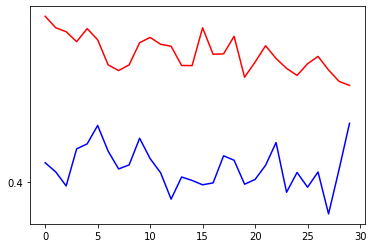

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


10m 42s (- -10m 40s) (231 770%) 0.4586
22m 27s (- -20m 26s) (232 773%) 0.4565
Saving Model State at:  232
34m 32s (- -31m 54s) (233 776%) 0.4766
46m 28s (- -41m 28s) (234 780%) 0.4842
57m 51s (- -51m 31s) (235 783%) 0.4563
Saving Model State at:  235
69m 17s (- -61m 30s) (236 786%) 0.4479
80m 51s (- -71m 22s) (237 790%) 0.4763
92m 40s (- -81m 0s) (238 793%) 0.4603
104m 16s (- -92m 48s) (239 796%) 0.4483
115m 55s (- -102m 34s) (240 800%) 0.4563
127m 28s (- -112m 23s) (241 803%) 0.4552
139m 0s (- -122m 13s) (242 806%) 0.4751
150m 45s (- -133m 51s) (243 810%) 0.4569
162m 22s (- -143m 35s) (244 813%) 0.4678
174m 18s (- -153m 2s) (245 816%) 0.4469
Saving Model State at:  245
186m 13s (- -164m 29s) (246 819%) 0.4521
197m 58s (- -174m 3s) (247 823%) 0.4450
209m 47s (- -185m 35s) (248 826%) 0.4696
221m 37s (- -195m 4s) (249 830%) 0.4485
233m 43s (- -206m 19s) (250 833%) 0.4640
245m 52s (- -217m 30s) (251 836%) 0.4693
257m 39s (- -227m 0s) (252 840%) 0.4554
269m 31s (- -238m 26s) (253 843%) 0.4

<Figure size 432x288 with 0 Axes>

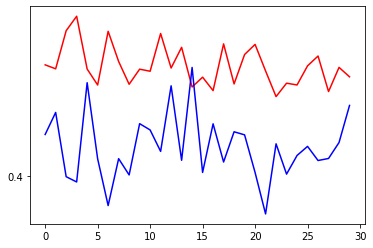

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

In [ ]:
train_from_checkpoint('/content/drive/My Drive/data/checkpoint/checkpoint.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


11m 1s (- -10m 19s) (246 819%) 0.5747
23m 8s (- -21m 39s) (247 823%) 0.5963
35m 17s (- -32m 58s) (248 826%) 0.5783
47m 25s (- -42m 17s) (249 830%) 0.5887
59m 35s (- -53m 33s) (250 833%) 0.5924
71m 45s (- -64m 49s) (251 836%) 0.5945
83m 44s (- -74m 13s) (252 840%) 0.5725
95m 52s (- -85m 29s) (253 843%) 0.5933
108m 9s (- -96m 36s) (254 846%) 0.6029
120m 28s (- -107m 41s) (255 850%) 0.6036
132m 37s (- -118m 55s) (256 853%) 0.5462
144m 52s (- -128m 2s) (257 856%) 0.6076
157m 2s (- -139m 12s) (258 860%) 0.6052
169m 9s (- -150m 26s) (259 863%) 0.5763
181m 24s (- -161m 31s) (260 866%) 0.5600
193m 31s (- -172m 43s) (261 869%) 0.5617
205m 41s (- -183m 51s) (262 873%) 0.5539


In [ ]:
encoder = Encoder(feature_extractor).to(device)
decoder = Decoder(343, len(wordtoint)).to(device)
model_states = torch.load('/content/drive/My Drive/data/checkpoint/checkpoint.pth', map_location=device)
encoder.load_state_dict(model_states["encoder_state_dict"])
decoder.load_state_dict(model_states["decoder_state_dict"])
arr = list(range(data_size))
Evaluate(encoder, decoder, arr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4307601654376706

In [ ]:
arr = list(range(data_size))
Evaluate(encoder, decoder, arr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4049858704039834

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


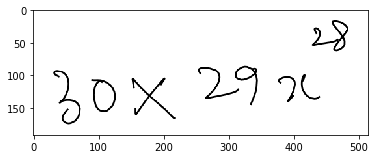

In [ ]:
%matplotlib inline
scores = []
indexs = list(range(data_size))
random.shuffle(indexs)
indexs = indexs[:1000]
for idx in indexs:
    img, tar = get_input_pair(idx)
    plt.imshow(cv2.imread(get_path("Images") + Image_file_names[idx]))
    img = img.to(device)
    tar = tar.to(device)
    encoder = encoder.eval()
    decoder = decoder.eval()
    out = encoder(img).reshape(200, -1)
    hid = decoder.initHidden().to(device)
    start = torch.tensor([SOS_token]).to(device)
    with open(get_path("MathML") + MathML_file_names[idx]) as f:
        arr = f.read().strip().split(" ")
    res = []
    for i in range(400):
        ans, hid, attn = decoder(start, hid, out)
        # print(inttoword[int(F.softmax(ans).argmax())],arr[i])
        res.append(inttoword[int(F.softmax(ans).argmax())])
        if(int(F.softmax(ans).argmax()) == EOS_token):
            break
        start = F.softmax(ans).argmax()
    scores.append(sentence_bleu(arr, res))
    with open('test.mathml', 'w') as f:
        f.write(" ".join(res))
    break
# showPlot(scores, [], "red")

In [ ]:
import pandas as pd
df = pd.DataFrame(scores)
df.describe()

,0
count,1.000000
mean,0.626284
std,NaN
min,0.626284
25%,0.626284
50%,0.626284
75%,0.626284
max,0.626284


In [ ]:
plot_scores = []
for i, s in enumerate(scores):
    if(i%10 == 0):
        plot_scores.append(s)

<Figure size 432x288 with 0 Axes>

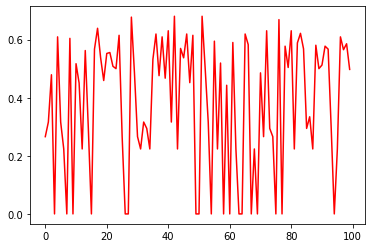

In [ ]:
showPlot(plot_scores, [], "")

In [ ]:
with open('test.mathml', 'r') as f:
    print(f.read())

<mrow> <mn> 3 </mn> <mrow> <mn> 0 </mn> <mrow> <mo> \times </mo> <mrow> <mn> 2 </mn> <mrow> <mn> 9 </mn> <msup> <mi> x </mi> <mrow> <mn> 2 </mn> <mn> 8 </mn> </mrow> </msup> </mrow> </mrow> </mrow> </mrow> </mrow> <EOS>


In [ ]:
indexs[0]

In [ ]:
# 6632
# 6935
# 10451
# 10404
# 8268
# 5131
# 5009
# 4042
# 1902

In [ ]:
!wget https://www.researchgate.net/profile/Ting_Zhang90/publication/324433547/figure/fig1/AS:614055790247948@1523413717398/Illustration-of-mathematical-expression-examples-a-A-simple-and-liner-expression.png

--2019-11-12 19:17:03--  https://www.researchgate.net/profile/Ting_Zhang90/publication/324433547/figure/fig1/AS:614055790247948@1523413717398/Illustration-of-mathematical-expression-examples-a-A-simple-and-liner-expression.png
Resolving www.researchgate.net (www.researchgate.net)... 104.17.33.105, 104.17.32.105
Connecting to www.researchgate.net (www.researchgate.net)|104.17.33.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16298 (16K) [image/png]
Saving to: ‘Illustration-of-mathematical-expression-examples-a-A-simple-and-liner-expression.png’

Illustration-of-mat 100%[===================>]  15.92K  --.-KB/s    in 0s      

2019-11-12 19:17:04 (150 MB/s) - ‘Illustration-of-mathematical-expression-examples-a-A-simple-and-liner-expression.png’ saved [16298/16298]



<mrow> <msup> <mi> X </mi> <mn> 2 </mn> </msup> <mi> u </mi> </mrow> <mrow> <mi> </mi> </mi> </mrow> <EOS>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


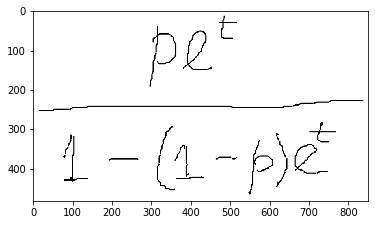

In [ ]:
%matplotlib inline
test_img_path = '/content/hello.png'
img = Image.open(test_img_path).convert("RGB")
img = Image_transform(img).unsqueeze(0)
plt.imshow(cv2.imread(test_img_path))
img = img.to(device)
tar = tar.to(device)
encoder = encoder.eval()
decoder = decoder.eval()
out = encoder(img).reshape(200, -1)
hid = decoder.initHidden().to(device)
start = torch.tensor([SOS_token]).to(device)
res = []
for i in range(400):
    ans, hid, attn = decoder(start, hid, out)
    res.append(inttoword[int(F.softmax(ans).argmax())])
    if(int(F.softmax(ans).argmax()) == EOS_token):
        break
    start = F.softmax(ans).argmax()
with open('test.mathml', 'w') as f:
    f.write(" ".join(res))

with open('test.mathml', 'r') as f:
    print(f.read())